In [1]:
%reset -f

In [2]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import math
import numpy as np

In [3]:
def get_phi(x):
    out = torch.zeros_like(x)
    out[(x >= -1) & (x < 0)] = x[(x >= -1) & (x < 0)] + 1
    out[(x >= 0) & (x <= 1)] = 1 - x[(x >= 0) & (x <= 1)]
    return out


    # mm = (3.2**2) * (1**2)
    # t = np.pi * x / 1
    # ss = np.sin(t)
    # ee = np.exp(-np.square(x) / (2 * mm))
    # out = ss * ee / t
    # out = torch.where(torch.isnan(out), torch.full_like(out, 1), out)
    # return out

In [4]:
def get_psi(j,k,x):
    return get_phi((2 ** (j+1)) * x - (2*k+1))

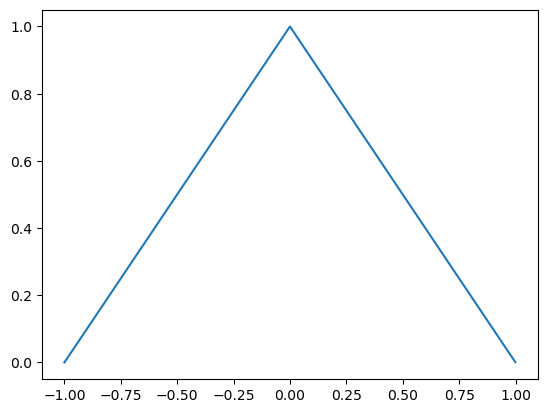

In [7]:
x = torch.arange(-1,1,1/1000)
xx = torch.arange(-10,10,1/1000)
phi_x = get_phi(x)
plt.plot(x.numpy(), phi_x.numpy())
plt.show()

插值特性：$\phi(k)=\left\{\begin{array}{ll}
1, & k=0 \\
0, & k \neq 0
\end{array}\right.$

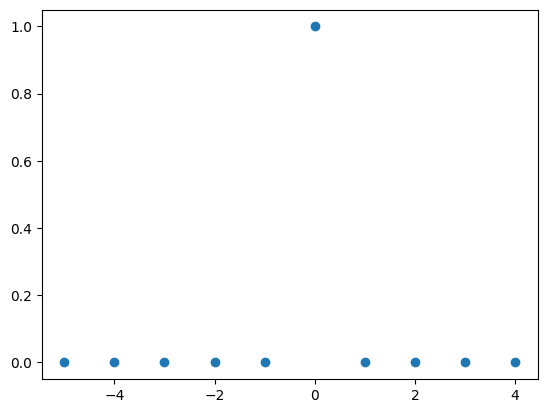

In [22]:
k = torch.arange(-5,5,1)
phi_k = get_phi(k)
plt.scatter(k.numpy(), phi_k.numpy())

双尺度关系：$\phi(x)=\sum\limits_{k \cup Z} \phi(k / 2) \phi(2 x-k)$

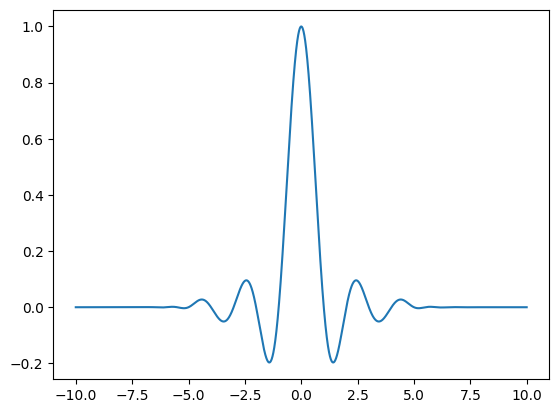

In [23]:
res = 0
for k in range(-10, 10):
    k = torch.tensor(k)
    res += get_phi(k/2)*get_phi(2*xx-k)
plt.plot(xx.numpy(), res.numpy())

多项式张成：对整数$D\ge0$，$\sum\limits_{k \in Z}C_k\phi(x-k)$能覆盖所有D阶多项式函数

对某一个正实数$R>0$，$\phi$是$R$阶Holder连续的，即
$$\big|\phi(y)-\phi(x)\big|\leq C\big|y-x\big|^R,\quad\forall x,y\in R$$

局部性：$\phi$及其$\lfloor m \rfloor$阶导数是紧支撑的，即：
$$\begin{aligned}\left|\phi^m(x)\right|\leq A_s\left(1+\left|x\right|\right)^{-s},\quad x\in R,\quad s>0,\quad0\leq m\leq\left\lfloor R\right\rfloor\end{aligned}$$

定义尺度函数序列为：$\phi_{j,k}(x)=\phi(2^j\:x-k)\quad k= \{0, 1, ..., 2^j\}$

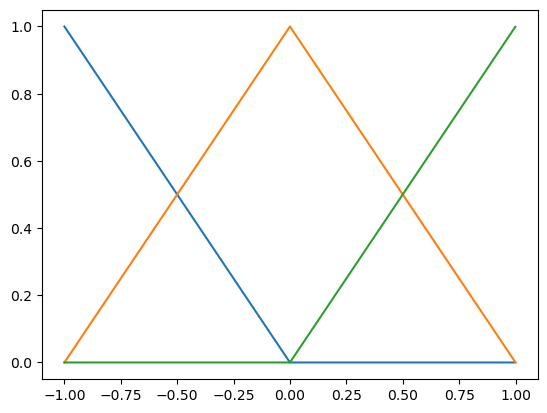

In [11]:
j = 0
for k in range(-2 ** j, 2 ** j + 1, 1):
    phi_jk = get_phi((2 ** j) * x - k)
    plt.plot(x.numpy(), phi_jk.numpy())
# phi_jk = get_phi((2 ** j) * x)
# plt.plot(x.numpy(), phi_jk.numpy())

In [25]:
n = 2
x_n = torch.tensor(n * 2 ** (-j))
for k in range(n-2,n+3):
    phi_jk_n2_j = get_phi((2 ** j) * x_n - k) ## n == k == 2
    phi_jk_n2_j = 0 if phi_jk_n2_j < 0.0001 else phi_jk_n2_j
    print("n={}, k={}, now phi_jk(n2^-j)={}".format(n, k, phi_jk_n2_j))

n=2, k=0, now phi_jk(n2^-j)=0
n=2, k=1, now phi_jk(n2^-j)=0
n=2, k=2, now phi_jk(n2^-j)=1.0
n=2, k=3, now phi_jk(n2^-j)=0
n=2, k=4, now phi_jk(n2^-j)=0


 $$u_J(x)=\sum\limits^{2^{j_0}}_{k_0=0}u(x_{j_0k_0})\phi_{j_0k_0}(x)+\sum\limits^{j-1}_{j=j_0}\sum\limits_{k \in Z^j}\alpha_{jk}\psi_{jk}(x)$$

In [26]:
class Iwt_module():
    def __init__(self, x, j0):
        self.idxs = [[0, len(x)/2, len(x)]]

    
    def get_Iwt_l(self, x, j, f):
        Ijf = 0
        for k in range(-2 ** j, 2 ** j + 1, 1):
            x_jk = torch.tensor(k * (2 ** (-j)))
            f_xjk = f(x_jk)
            phi_jk = get_phi((2 ** j) * x - k)
            Ijf += f_xjk * phi_jk
        return Ijf

    def get_alpha_jk(self, x, j, k, f, u, th):
        y_jk = torch.tensor((2*k+1) * (2 ** (-j-1)))
        f_yjk = f(y_jk)
        diff = torch.abs(x - y_jk)
        idx = torch.argmin(diff)
        mask = torch.zeros_like(x)
        mask[idx] = 1
        mask = mask.type(torch.int)
        indices = torch.nonzero(mask).reshape(-1)
        diff2 = torch.abs(f_yjk - u[indices])
        if diff2 > th:
            return f_yjk - u[indices], indices
        else:
            return 0, 0

    def get_Iwt(self, x, j0, J, f, e):
        if J == 0:
            return self.get_Iwt_l(x, J, f)
        j = J-1
        Iwt_r = 0
        if j == j0:
            indicies = []
            u0 = self.get_Iwt_l(x, j0, f)
            for k in range(-2 ** j, 2 ** j, 1):
                alpha_jk, i = self.get_alpha_jk(x, j, k, f, u0, th=e * math.sqrt(2 **(-j)))
                if i > 0:
                    indicies.append(i.item())
                psi_jk = get_phi((2 ** (j+1)) * x - (2*k+1))
                Iwt_r += alpha_jk * psi_jk
            self.idxs.append(indicies)
            return u0 + Iwt_r
        elif j > j0:
            indicies = []
            u_j1 = self.get_Iwt(x, j0, j, f, e)
            for k in range(-2 ** j, 2 ** j, 1):
                alpha_jk, i = self.get_alpha_jk(x, j, k, f, u_j1, th=e * math.sqrt(2 **(-j)))
                if i > 0:
                    indicies.append(i.item())
                psi_jk = get_psi(j, k, x)
                Iwt_r += alpha_jk * psi_jk
            self.idxs.append(indicies)
            return u_j1 + Iwt_r
        else:
            return self.get_Iwt_l(j0, f)

In [27]:
def func1(x):
    return 4*(x ** 3) - 3 * x

def func2(x):
    return torch.sigmoid(60*x)

def func3(x):
    return torch.sin(400 * x**3) * torch.exp(-30 * x**2)

def func4(x):
    return torch.sin(5*x)

def func5(x):
    y1 = torch.zeros_like(x)
    y1 = torch.where((x <= 0), (x+1)**2, (1-x))
    return y1


In [28]:
# plt.plot(x.numpy(), func4(x).numpy(), label="func")

In [29]:
j0 = 0
J = 6
f = func4

In [43]:
Iwt_m1 = Iwt_module(x, j0)
Iwt_m2 = Iwt_module(x, j0)
Iwt = Iwt_m1.get_Iwt(x, j0, J, f, 0)
Iwt2 = Iwt_m2.get_Iwt(x, J-1, J, f, 0)

print(sum([len(i) for i in Iwt_m1.idxs]))
print(sum([len(i) for i in Iwt_m2.idxs]))

129
67


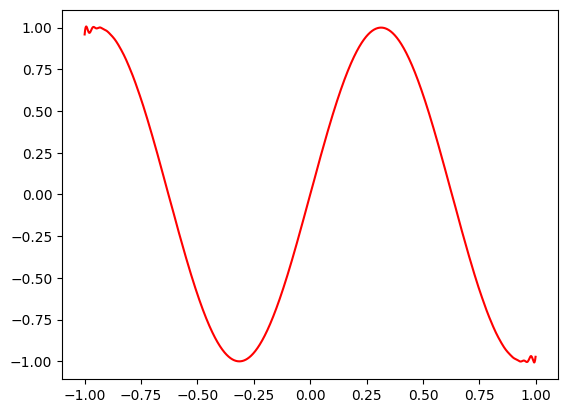

In [41]:

# plt.plot(x.numpy(), Iwt.numpy(), label = "no threshold")
# plt.legend()
# plt.figure()
plt.plot(x.numpy(), Iwt2.numpy(), "r", label = "")
# plt.legend()
# plt.figure()
# plt.plot(x.numpy(), f(x).numpy(), "k--", label="func")
# plt.legend()
plt.show()

Text(0.5, 1.0, 'self-adaptive interp')

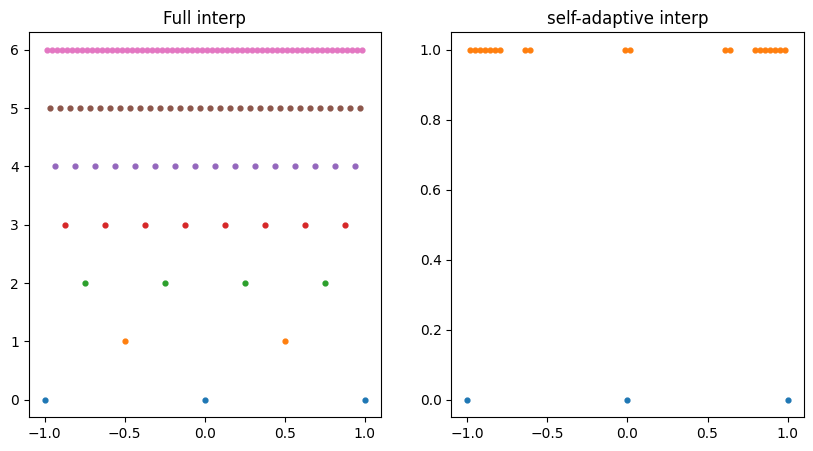

<Figure size 640x480 with 0 Axes>

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
for i, idx_e in enumerate(Iwt_m1.idxs):
    idx_e = (torch.tensor(idx_e) - (len(x)/2.)) / (len(x)/2.)
    axs[0].scatter(idx_e.numpy(), np.ones_like(idx_e) * i, s=12)
plt.figure()
for i, idx_e in enumerate(Iwt_m2.idxs):
    idx_e = (torch.tensor(idx_e) - (len(x)/2.)) / (len(x)/2.)
    axs[1].scatter(idx_e.numpy(), np.ones_like(idx_e) * i, s=12)

axs[0].set_title('Full interp')
axs[1].set_title('self-adaptive interp')